In [4]:
# Standard imports
from glob import glob
import re
import os
import itertools
import sys

# Third party imports
from statsmodels.stats.multitest import multipletests, local_fdr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Set root directory
root = '/home/adri/Projects/phd/bias_2'
os.chdir(root)

# local imports
sys.path.append('src/utils')
from loaders import load_signaling_df
from src.analysis.generate_toy_network import *


# Load data

In [5]:
# Set the type of network to use
ACN = 'ACN_0.1_1'

In [6]:
# Load all distance dataframes into a single df
path_pattern = f'{root}/results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/allosteric_network_distance/dist*.csv'
df_list = []
for df_path in glob(path_pattern):
    df = pd.read_csv(df_path, index_col=0)
    df_list.append(df)
df = pd.concat(df_list).reset_index(drop=True)

In [7]:
df

,distance,residue,theshold,type
0,0.014073,48,0.126,weighted
1,0.013073,50,0.126,weighted
2,0.017073,54,0.126,weighted
3,0.014027,55,0.126,weighted
4,0.029099,61,0.126,weighted
...,...,...,...,...
34155,0.000000,302,0.122,unweighted
34156,0.000000,305,0.122,unweighted
34157,1.000000,307,0.122,unweighted
34158,2.000000,310,0.122,unweighted


# Distance

In [8]:
# Patch to avoid having to rerun distance calculations
df = df.rename(columns={'theshold': 'threshold'})

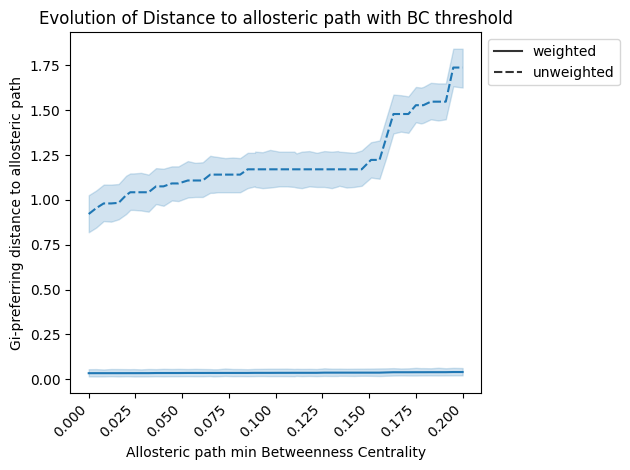

In [9]:
# plt.figure(dpi=300)
sns.lineplot(data=df, y='distance', x='threshold', style='type')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')

plt.xlabel('Allosteric path min Betweenness Centrality')
plt.ylabel('Gi-preferring distance to allosteric path')
plt.title('Evolution of Distance to allosteric path with BC threshold')
plt.tight_layout()
plt.show()

# Test mutant proximity to allosteric pathway

In [10]:
dist_path = f'{root}/results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/allosteric_network_distance/dist*.csv'

In [11]:
# Perform hypothesis tests
N = len(glob(dist_path))

p_val_df = []
for path, graph_type in itertools.product(glob(dist_path), ['unweighted']):

    # Get threshold from path
    threshold = re.findall(r'_t(\d+).csv', path)[0]

    # Load and filter dataframe
    dist_df = pd.read_csv(path, index_col=0)
    dist_df = dist_df[dist_df.type == graph_type]

    # Load random distribution
    random_path = os.path.dirname(path) + '/random_' + os.path.basename(path)
    random_dist_df = pd.read_csv(random_path, index_col=0)
    random_dist_df = random_dist_df[random_dist_df.type == graph_type]

    # Compute Z score of the true mean distance to the random mean distribution
    mean_random_dists = random_dist_df.groupby(
        'replica').distance.mean().values
    mean_random_dist = mean_random_dists.mean()
    random_dist_std = mean_random_dists.std()
    true_mean_dist = dist_df.distance.mean()
    z_score = (true_mean_dist - mean_random_dist)/random_dist_std

    # Compute the p-value
    p_value = (true_mean_dist > mean_random_dists).mean()
    threshold = float(f'0.{threshold}')

    # Build dataframe
    p_val_df.append([p_value, threshold, graph_type, z_score])

p_val_df = pd.DataFrame(
    p_val_df, columns=['p_value', 'threshold', 'type', 'z_score'])
p_val_df.threshold = p_val_df.threshold.round(3)

In [12]:
p_val_df.sort_values('z_score')

,p_value,threshold,type,z_score
178,0.006,0.146,unweighted,-2.585904
71,0.004,0.142,unweighted,-2.583843
150,0.011,0.126,unweighted,-2.554535
23,0.009,0.133,unweighted,-2.553288
149,0.004,0.138,unweighted,-2.538973
...,...,...,...,...
271,0.380,0.000,unweighted,-0.276682
135,0.383,0.004,unweighted,-0.267927
75,0.429,0.008,unweighted,-0.250136
239,0.404,0.004,unweighted,-0.220061


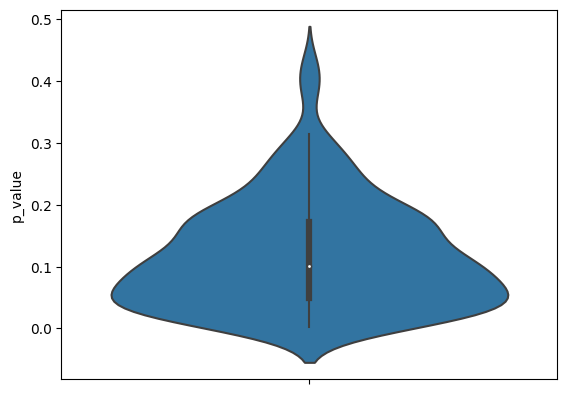

In [13]:
# plt.figure(dpi=150)
sns.violinplot(data=p_val_df, y='p_value', hue='type')
plt.show()

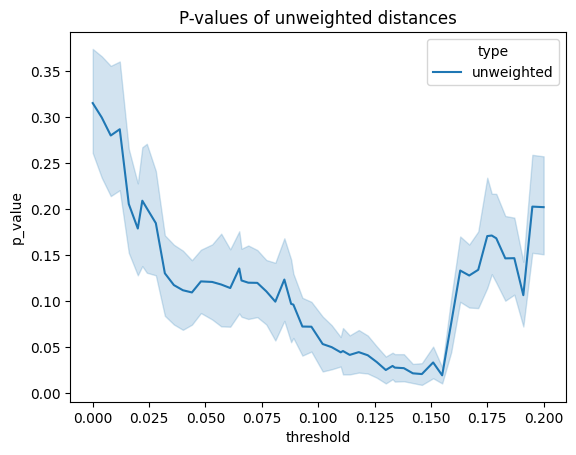

In [14]:
# plt.figure(dpi=300)
g = sns.lineplot(data=p_val_df, x='threshold', y='p_value', hue='type')
plt.title('P-values of unweighted distances')

plt.show()

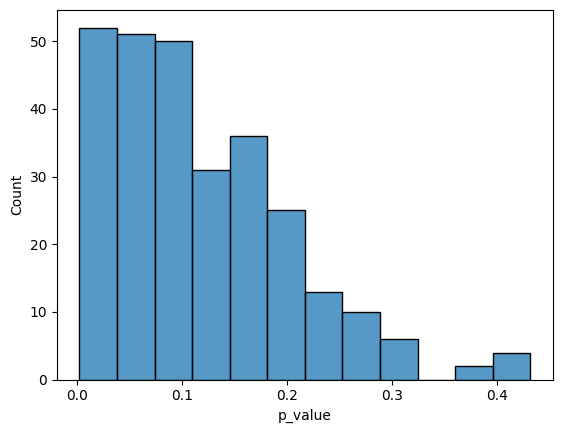

In [15]:
# plt.figure(dpi=300)
sns.histplot(p_val_df, x='p_value')
plt.show()

In [16]:
mean_pval = p_val_df.sort_values('p_value').groupby('threshold').p_value.mean()

In [17]:
mean_pval = mean_pval.iloc[::4]

In [18]:
pvals = mean_pval.values

In [19]:
reject, pvals_corrected, _, _ = multipletests(
    pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

In [20]:
pvals_corrected

array([0.315     , 0.2212    , 0.21536667, 0.18635556, 0.18635556,
       0.18635556, 0.18635556, 0.18635556, 0.18635556, 0.1764    ,
       0.1764    , 0.18635556, 0.21536667, 0.20524   ])

In [21]:
# Correct for multiple testing
type_mask = p_val_df.type == 'unweighted'
# Select only path 12 and unweighted distances
good_thresholds = np.sort(p_val_df.threshold.unique())[
    range(0, len(p_val_df.threshold.unique()), 4)]
# Get a mask for thresholds in good_thresholds
threshold_mask = p_val_df.threshold.isin(good_thresholds)
filtered_p_val_df = p_val_df[threshold_mask]

pvals = filtered_p_val_df[type_mask].p_value
# reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
# correct p-values using bonferroni correction
reject, pvals_corrected, _, _ = multipletests(
    pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

filtered_p_val_df['pvals_corrected'] = pvals_corrected
# Show the best Betweenness centrality threshold in terms of pvalues
filtered_p_val_df.sort_values(['z_score']).head()

/tmp/ipykernel_3023502/1833361813.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pvals = filtered_p_val_df[type_mask].p_value
/tmp/ipykernel_3023502/1833361813.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_p_val_df['pvals_corrected'] = pvals_corrected


,p_value,threshold,type,z_score,pvals_corrected
71,0.004,0.142,unweighted,-2.583843,0.28
206,0.002,0.130,unweighted,-2.532897,0.14
111,0.009,0.102,unweighted,-2.287625,0.63
254,0.010,0.130,unweighted,-2.283215,0.70
179,0.015,0.114,unweighted,-2.250313,1.00


In [22]:
best_threshold = p_val_df.sort_values(['z_score']).threshold.iloc[0]
best_threshold_str =  str(best_threshold.round(3)).split('.')[1][:3]
# right pad the number with 0 to have 3 digits
best_threshold_str = best_threshold_str + '0'*(3-len(best_threshold_str))

In [23]:
p_val_df.sort_values(['z_score'])

,p_value,threshold,type,z_score
178,0.006,0.146,unweighted,-2.585904
71,0.004,0.142,unweighted,-2.583843
150,0.011,0.126,unweighted,-2.554535
23,0.009,0.133,unweighted,-2.553288
149,0.004,0.138,unweighted,-2.538973
...,...,...,...,...
271,0.380,0.000,unweighted,-0.276682
135,0.383,0.004,unweighted,-0.267927
75,0.429,0.008,unweighted,-0.250136
239,0.404,0.004,unweighted,-0.220061


In [24]:
print(best_threshold_str)
print(best_threshold)

146
0.146


# Plot Null hypothesis along with true value

In [25]:
def plot_null(dist_df, random_dist_df, type):
    """"""

    plt.figure(dpi=150)
    random_values = random_dist_df[random_dist_df.type == type].groupby(
        'replica').distance.mean()
    true_mean = dist_df[dist_df.type == type].distance.mean()
    sns.histplot(random_values)
    plt.axvline(true_mean, color='red')
    plt.show()

In [26]:
# Load true distances and random ones
threshold_str = best_threshold_str
distance_path = f'{root}/results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/allosteric_network_distance'
file_name_list = glob(
    f'{distance_path}/dist_to_pathway_r*_t{threshold_str}.csv')
dist_df_list = []
for file_name in file_name_list:
    dist_df = pd.read_csv(file_name, index_col=0)
    dist_df_list.append(dist_df)

file_name = glob(
    f'{distance_path}/random_dist_to_pathway_r1_t{threshold_str}.csv')[0]
random_dist_df = pd.read_csv(file_name, index_col=0).reset_index(drop=True)

In [27]:
dist_df = pd.concat(dist_df_list).groupby(
    ['residue', 'theshold', 'type']).distance.mean().reset_index()

In [28]:
dist_df

,residue,theshold,type,distance
0,48,0.146,unweighted,1.000000
1,48,0.146,weighted,0.013471
2,50,0.146,unweighted,1.000000
3,50,0.146,weighted,0.012271
4,54,0.146,unweighted,1.000000
...,...,...,...,...
117,307,0.146,weighted,0.002404
118,310,0.146,unweighted,2.000000
119,310,0.146,weighted,0.044484
120,317,0.146,unweighted,3.000000


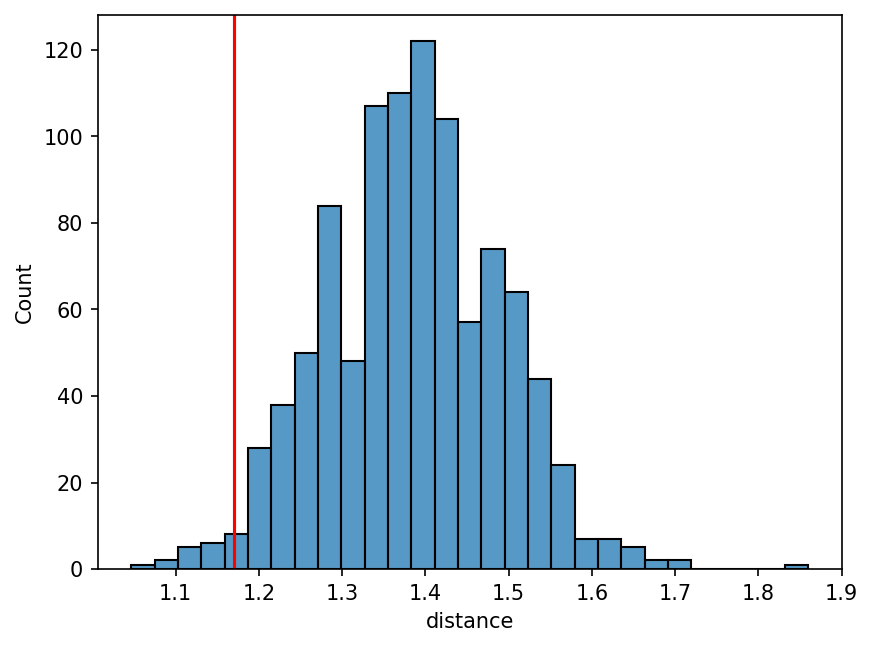

In [29]:
plot_null(dist_df, random_dist_df, 'unweighted')

# Compare Distances between Real data and random 

In [30]:
# Load unweighted distances
unweighted_dists = dist_df[dist_df.type == 'unweighted']
random_unweighted_dists = random_dist_df[random_dist_df.type == 'unweighted']

# Load random unweighted distances
unweighted_dists.loc[:, 'distance'] = unweighted_dists.loc[:,
                                                           'distance'].astype(int)
random_unweighted_dists.loc[:,
                            'distance'] = random_unweighted_dists.loc[:, 'distance'].astype(int)

# Create variable to distinguish between true and random data
unweighted_dists.loc[:, 'set'] = 'true'
random_unweighted_dists.loc[:, 'set'] = 'null'

# Concatenate dataframes
all_unweighted_dists = pd.concat([unweighted_dists, random_unweighted_dists])

/tmp/ipykernel_3023502/885662619.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unweighted_dists.loc[:, 'set'] = 'true'
/tmp/ipykernel_3023502/885662619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_unweighted_dists.loc[:, 'set'] = 'null'


In [31]:
# Load the averaged contact graph
graph_path = f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/nw_pickles/WT/1.pickle'
g = preprocess_graph(graph_path)

# Load the filtered allosteric pathway
pathway_path = f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/transition_matrices/WT_transition_matrix.csv'

path_df = parse_pathway_data(pathway_path)
filtered_path_df = path_df[path_df.value > best_threshold]

# Get residues involved in this pathway
pathway_residues = np.unique(np.concatenate([filtered_path_df['r1'].values,
                                             filtered_path_df['r2'].values])).tolist()

# Get residues that are wt-like
signaling_df = load_signaling_df()
wt_like_residues = signaling_df[signaling_df['profile']
                                == 0].index.values.tolist()
# cast to int
wt_like_residues = [int(res) for res in wt_like_residues]

# Plot the distance distribution for wt-like mutants
wt_distance_df = get_distances_to_shortest_pathway(
    g, pathway_residues, wt_like_residues)

In [32]:
# compute all distances to the shortest pathway
shortest_pathway_distances = get_distances_to_shortest_pathway(
    g, pathway_residues, [int(idx) for idx in signaling_df.index.values.tolist()])

In [33]:
all_distance_counts = shortest_pathway_distances.distance.value_counts()

In [34]:
wt_distance_df['set'] = 'wt-like'

In [35]:
all_unweighted_dists = all_unweighted_dists[['distance', 'residue', 'set']]

In [36]:
all_unweighted_dists

,distance,residue,set
0,1.0,48.0,true
2,1.0,50.0,true
4,1.0,54.0,true
6,1.0,55.0,true
8,1.0,61.0,true
...,...,...,...
63995,2.0,NaN,null
63996,2.0,NaN,null
63997,1.0,NaN,null
63998,1.0,NaN,null


In [37]:
all_all_unweighted_dists = pd.concat([all_unweighted_dists, wt_distance_df])

In [38]:
# Create a dataframe with the proportion of residues N edges away from the allosteric path
distance_counts = all_all_unweighted_dists.groupby(
    'set').distance.value_counts(normalize=True)
distance_counts.name = 'proportion'
distance_counts = distance_counts.reset_index()

/tmp/ipykernel_3023502/2270745226.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.proportion = temp_df.proportion * 100


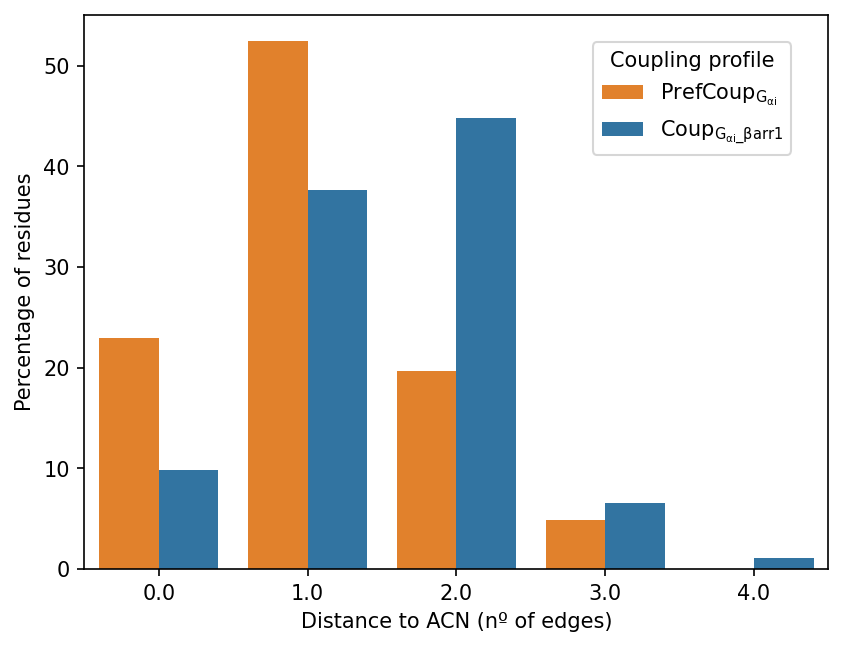

In [39]:
plt.figure(dpi=150)

mycolors = np.array(sns.color_palette()[:5])
# colors = [sns.color_palette()[7]] + sns.color_palette()[1::-1]
colors = sns.color_palette()[1::-1]
# make temp df with only true and wt-like mutnats
temp_df = distance_counts[distance_counts.set.isin(['true', 'wt-like'])]
temp_df.proportion = temp_df.proportion * 100
g = sns.barplot(data=temp_df, x='distance',
                y='proportion', hue='set', palette=colors)

# change Legend labels from true, wt-like to PrefCoup gi and Coup
handles, labels = g.get_legend_handles_labels()
labels = [r'$\mathrm{PrefCoup_{G_{\alpha i}}}$', r'$\mathrm{Coup_{G_{\alpha i}\_\beta arr1}}$']
# set legend title to Set
legend_title = 'Coupling profile'
g.legend(handles=handles, labels=labels, title=legend_title, bbox_to_anchor=(0.95, 0.95), 
loc='upper right', borderaxespad=0.)



# for bar, color in zip(g.patches, colors):
#     bar.set_facecolor(color)

# sorted_patches = [i for pair in zip(g.patches[1:7], g.patches[7:13]) for i in pair]

# plt.legend(handles=sorted_patches,
#            labels=[''] * 8 + ['Null', 'True'], ncol=5,
#            handletextpad=0.5, handlelength=0.5, columnspacing=-0.5)

plt.xlabel('Distance to ACN (nº of edges)')
plt.ylabel('Percentage of residues')

# plt.tight_layout()
plt.show()

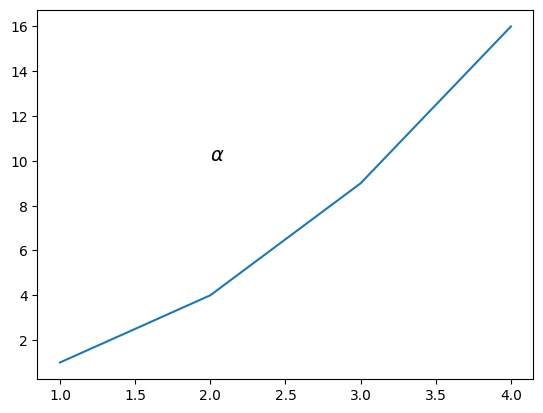

In [40]:
# Create a simple plot
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])

# Include text with the alpha symbol
plt.text(2, 10, r'$\alpha$', fontsize=14)

# Show the plot
plt.show()

In [41]:
# Load the averaged contact graph
graph_path = f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/nw_pickles/WT/1.pickle'
g = preprocess_graph(graph_path)

# Load the filtered allosteric pathway
pathway_path = f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/transition_matrices/WT_transition_matrix.csv'

path_df = parse_pathway_data(pathway_path)
best_threshold = float(f'0.{best_threshold_str}')
filtered_path_df = path_df[path_df.value > best_threshold]

# Get residues involved in this pathway
pathway_residues = np.unique(np.concatenate([filtered_path_df['r1'].values,
                                             filtered_path_df['r2'].values])).tolist()

# Get residues that are wt-like
signaling_df = load_signaling_df()
wt_like_residues = signaling_df[signaling_df['profile']
                                == 0].index.values.tolist()
# cast to int
wt_like_residues = [int(res) for res in wt_like_residues]

# Plot the distance distribution for wt-like mutants
wt_distance_df = get_distances_to_shortest_pathway(
    g, pathway_residues, wt_like_residues)

# Create a dataframe with the proportion of residues N edges away from the allosteric path
wt_distance_counts = wt_distance_df.distance.value_counts(normalize=True)
wt_distance_counts.name = 'proportion'
wt_distance_counts = wt_distance_counts.reset_index()
# rename index to distance
wt_distance_counts = wt_distance_counts.rename(columns={'index': 'distance'})

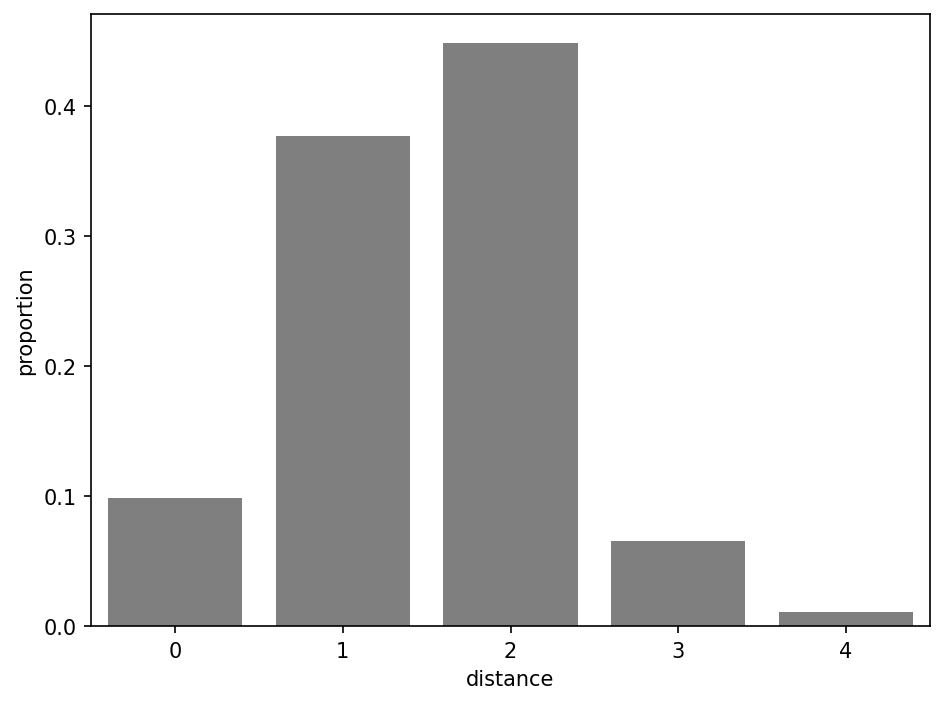

In [42]:
plt.figure(dpi=150)

mycolors = np.array(sns.color_palette()[:5])
g = sns.barplot(data=wt_distance_counts, x='distance', y='proportion', color=sns.color_palette()[7])

plt.tight_layout()
plt.show()

# Check distances of cluster interaction to the path

In [43]:
# Load the averaged contact graph
graph_path = f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/nw_pickles/WT/1.pickle'
graph = preprocess_graph(graph_path)

In [44]:
# Load the filtered allosteric pathway
pathway_path = f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/transition_matrices/WT_transition_matrix.csv'

path_df = parse_pathway_data(pathway_path)
filtered_path_df = path_df[path_df.value > best_threshold]

In [45]:
# Get residues involved in this pathway
pathway_residues = np.unique(np.concatenate([filtered_path_df['r1'].values,
                                             filtered_path_df['r2'].values])).tolist()

In [46]:
# Load microswitch cluster contacts
cluster_contacts = pd.read_csv(
    'results/clustering/ms_connections.csv', index_col=0)

In [47]:
# Separate the residues from each interaction
cluster_res_list = []
for i, row in cluster_contacts.iterrows():
    feature = row['feature']
    group = row['group']

    for r in feature.split('-'):
        cluster_res_list.append([group, r])

cluster_res_list = pd.DataFrame(cluster_res_list, columns=['group', 'res'])

In [48]:
cluster_distance_df = get_distances_to_shortest_pathway(graph, pathway_residues,
                                                        cluster_res_list.res.astype(int).tolist())

In [49]:
cluster_res_list['distance'] = cluster_distance_df.distance

In [50]:
cluster_res_list = cluster_res_list.drop_duplicates()

In [51]:
cluster_res_list

,group,res,distance
0,1,109,1
1,1,93,1
2,1,180,2
3,1,25,1
5,1,94,1
...,...,...,...
112,3,299,0
113,3,51,1
114,3,91,1
117,3,80,1


In [52]:
distance_list = []
for feature in cluster_contacts.feature:

    print(feature)
    r1, r2 = feature.split('-')

    print(r1, r2)
    dist_list = []
    for r in (r1, r2):
        distance = cluster_res_list[cluster_res_list.res == r].distance.iloc[0]
        print(distance)
        dist_list.append(distance)

    distance_list.append(min(dist_list))

109-93
109 93
1
1
180-25
180 25
2
1
25-94
25 94
1
1
26-95
26 95
0
0
127-209
127 209
1
1
93-96
93 96
1
2
25-281
25 281
1
0
128-209
128 209
1
1
132-212
132 212
1
1
172-189
172 189
3
2
136-140
136 140
2
2
65-71
65 71
1
0
195-258
195 258
2
1
87-90
87 90
0
1
125-204
125 204
0
1
120-80
120 80
1
1
109-94
109 94
1
1
25-26
25 26
1
0
131-212
131 212
0
1
209-248
209 248
1
1
109-93
109 93
1
1
244-247
244 247
0
1
37-96
37 96
2
2
289-40
289 40
0
1
288-87
288 87
0
0
258-291
258 291
1
0
34-35
34 35
2
2
258-288
258 288
1
0
26-95
26 95
0
0
285-87
285 87
0
0
127-131
127 131
1
0
285-91
285 91
0
1
124-247
124 247
2
1
67-71
67 71
1
0
40-87
40 87
1
0
292-47
292 47
0
1
25-27
25 27
1
1
65-71
65 71
1
0
92-95
92 95
1
0
127-69
127 69
1
0
33-96
33 96
1
2
92-95
92 95
1
0
93-95
93 95
1
0
182-25
182 25
1
1
26-95
26 95
0
0
25-278
25 278
1
0
209-247
209 247
1
1
245-302
245 302
1
0
282-286
282 286
1
0
44-84
44 84
1
1
127-131
127 131
1
0
31-35
31 35
2
2
27-281
27 281
1
0
113-87
113 87
1
0
131-246
131 246
0
0
267-277
267 

In [53]:
cluster_contacts['min_dist'] = distance_list

In [54]:
cluster_contacts_count = cluster_contacts.groupby(
    'group').min_dist.value_counts()

In [55]:
cluster_contacts_count.name = 'count'

In [56]:
cluster_contacts_count = cluster_contacts_count.reset_index()

In [57]:
cluster_contacts_count

,group,min_dist,count
0,1,1,11
1,1,0,7
2,1,2,2
3,2,0,15
4,2,1,3
5,2,2,2
6,3,0,13
7,3,1,6
8,3,2,1


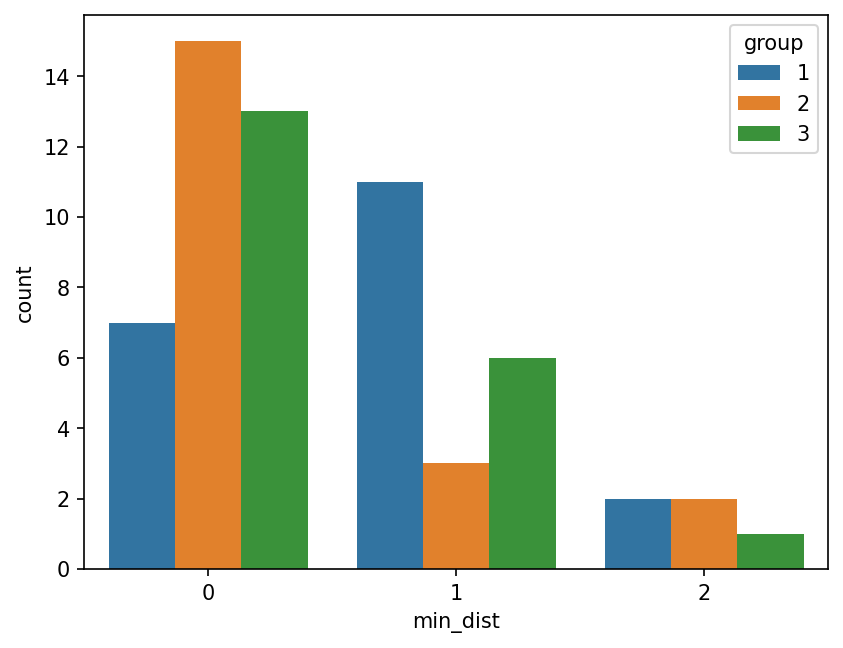

In [58]:
plt.figure(dpi=150)
sns.barplot(data=cluster_contacts_count, x='min_dist', y='count', hue='group')
plt.show()

In [59]:
cluster_res_list.res = cluster_res_list.res.astype(int)

In [60]:
distance_cluster_res = pd.merge(
    cluster_res_list, cluster_distance_df, left_on='res', right_on='residue')

In [61]:
cluster_distance_count = pd.DataFrame(cluster_res_list.groupby(
    ['group']).distance.value_counts(normalize=True))

In [62]:
cluster_distance_count.columns = ['count']

In [63]:
cluster_distance_count = cluster_distance_count.reset_index()

In [64]:
cluster_distance_count

,group,distance,count
0,1,1,0.533333
1,1,0,0.233333
2,1,2,0.200000
3,1,3,0.033333
4,2,1,0.433333
5,2,0,0.400000
6,2,2,0.166667
7,3,1,0.545455
8,3,0,0.333333
9,3,2,0.121212


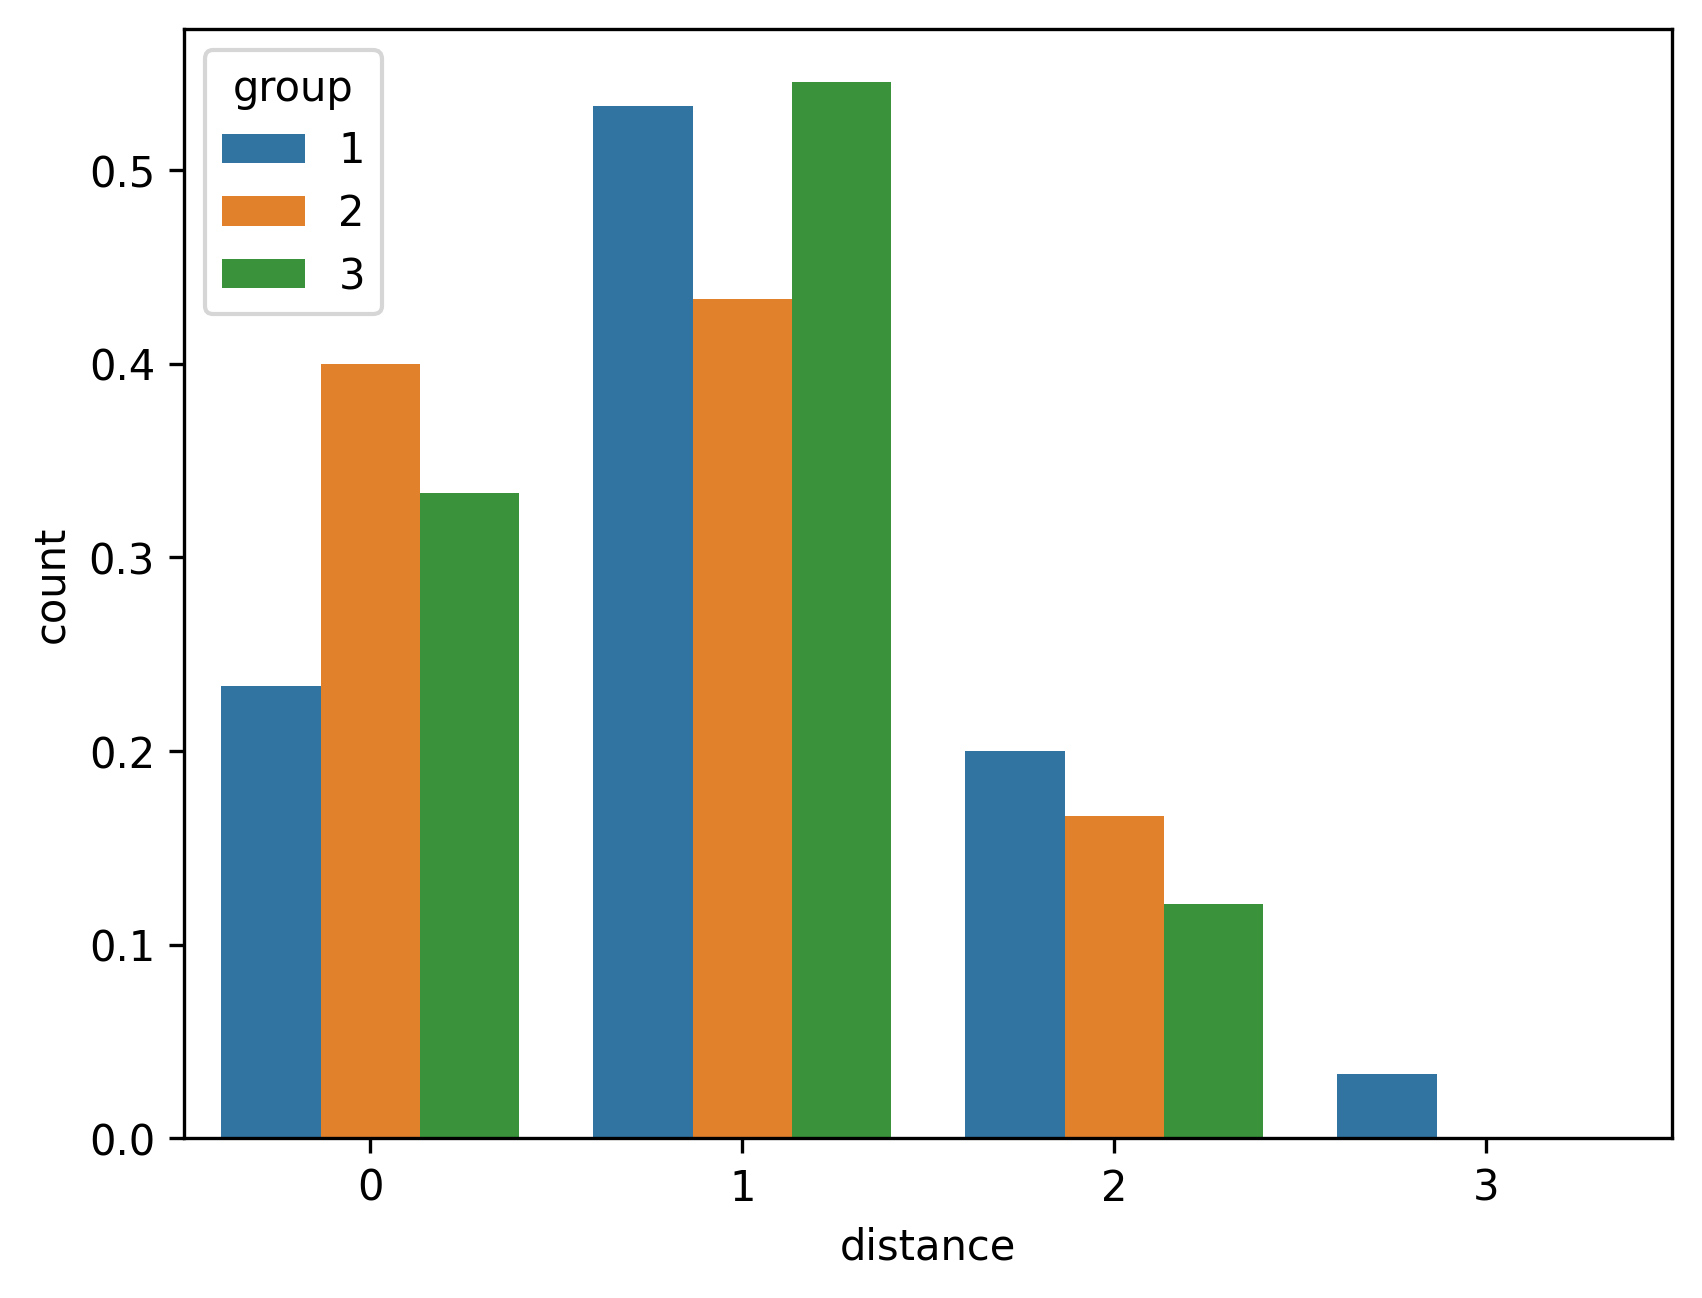

In [65]:
plt.figure(dpi=300)
sns.barplot(data=cluster_distance_count, x='distance', y='count', hue='group')
plt.show()

In [66]:
from loaders import load_signaling_df
import sys
import os
os.chdir('/home/adri/Projects/phd/bias_2')
sys.path.append('src/utils')

In [67]:
def get_gi_preferred_mutants():
    signaling_df = load_signaling_df()
    gi_preferred_mutants = signaling_df.index[signaling_df.profile == 1].astype(
        int).values
    return gi_preferred_mutants

In [68]:
get_gi_preferred_mutants().size

64

In [69]:
filtered_path_df.to_csv(f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/'
                        'allosteric_network_distance/filtered_allosteric_path.csv')

# Mutant shortest path

In [83]:
import os
import pandas as pd
from glob import glob
import re
import sys

import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
# Change the working directory to the root of the project
root = '/home/adri/Projects/phd/bias_2'
os.chdir(root)

In [85]:
from loaders import load_signaling_df
sys.path.append('src/utils')

In [86]:
# Helper functions for allosteric pathway parsing
def process_resid(res_id):
    residx = int(res_id.split(':')[-1])
    return residx


def parse_pathway_data(path):

    df = pd.read_csv(path, index_col=0)
    df = df.reset_index()
    df = df.melt(id_vars='index', var_name='r2')
    df = df.rename(columns={'index': 'r1'})
    df = df[df.value != 0]
    df.r1 = df.r1.apply(process_resid)
    df.r2 = df.r2.apply(process_resid)
    return df


def path_df_to_list(path_df, threshold):

    filgered_df = path_df[path_df.value > threshold]
    shortest_path_nodes = np.unique(filgered_df[['r1', 'r2']].values.flatten())
    shortest_path_nodes = shortest_path_nodes.tolist()
    return shortest_path_nodes

In [87]:
# Declare root pathway path
base_pathway_path = f"results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/"\
    'transition_matrices'

In [88]:
allosteric_pathway_dict = {}
# Get list of edges for pathways in all mutants
for pathway_path in glob(f'{base_pathway_path}/*.csv'):
    pathway_list = parse_pathway_data(pathway_path)
    # Make a mask to select residues with a frequency above 0.089
    threshold = best_threshold
    threshold_mask = pathway_list.value > threshold
    pathway_list = pathway_list[threshold_mask]

    # Get mutant id from pathway_path

    mutant_id = re.findall(r'(.+?)_transition_matrix.csv',
                           os.path.basename(pathway_path))[0]

    # Build a list of edges in the pathway
    pathway_edges = []
    for i, row in pathway_list.iterrows():
        # Join int casted residues with a dash
        edge_str = '-'.join([str(int(row.r1)), str(int(row.r2))])
        pathway_edges.append(edge_str)

    # Add the pathway edges to the dictionary
    allosteric_pathway_dict[mutant_id] = pathway_edges

In [89]:
signaling_df = load_signaling_df()

In [90]:
# Compute jaccard coefficient between the wild type and each mutant
wt_pathway_edges = allosteric_pathway_dict['WT']
jaccard_list = []
for mutant_id, pathway_edges in allosteric_pathway_dict.items():

    # Compute the jaccard coefficient
    jaccard_coeff = len(set(wt_pathway_edges).intersection(
        pathway_edges)) / len(set(wt_pathway_edges).union(pathway_edges))

    # create a variable to store signaling profile of the mutant
    if mutant_id in ['WT', '76']:
        continue

    signaling_profile = signaling_df.loc[mutant_id].profile

    jaccard_list.append([mutant_id, jaccard_coeff, signaling_profile])

# cast the list into a dataframe
jaccard_df = pd.DataFrame(jaccard_list, columns=[
                          'mutant_id', 'jaccard_coeff', 'signaling_profile'])

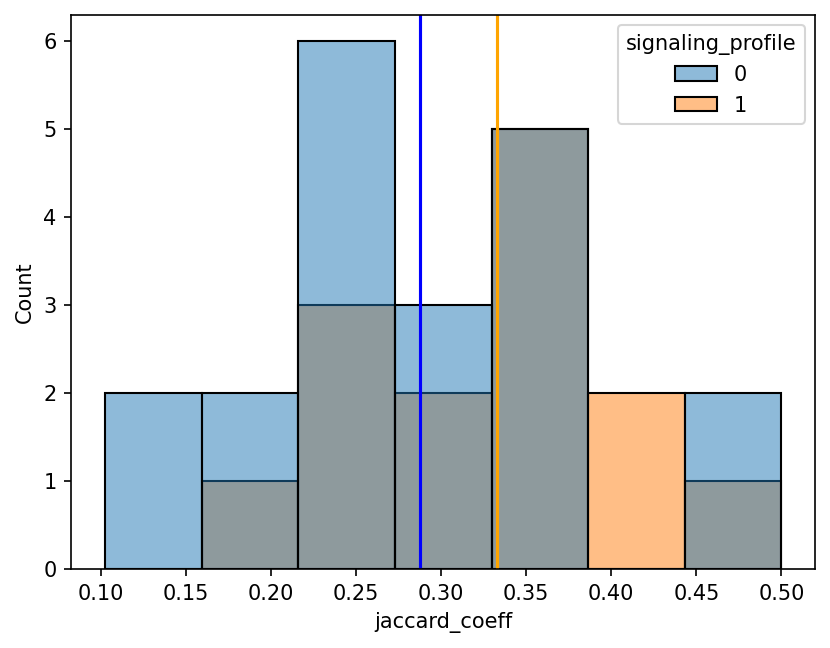

In [91]:
# Plot histogram of jaccard coefficients
plt.figure(dpi=150)
sns.histplot(data=jaccard_df, x='jaccard_coeff', hue='signaling_profile')
# add means for each signlaing profile as vertical lines
wt_like_mean = jaccard_df[jaccard_df.signaling_profile ==
                          0].jaccard_coeff.mean()
gi_like_mean = jaccard_df[jaccard_df.signaling_profile ==
                          1].jaccard_coeff.mean()
plt.axvline(wt_like_mean, color='blue')
plt.axvline(gi_like_mean, color='orange')
plt.show()

In [92]:
# Plot the distribution of path lengths for each signaling profile
path_length_dict = {}
for mutant_id, pathway_edges in allosteric_pathway_dict.items():

    # create a variable to store signaling profile of the mutant
    if mutant_id in ['WT', '76']:
        continue

    signaling_profile = signaling_df.loc[mutant_id].profile

    # Get the path length of the pathway
    path_length = len(pathway_edges)

    # Add the path length to the dictionary
    path_length_dict[mutant_id] = [signaling_profile, path_length]
# cast path length dict into a dataframe
path_length_df = pd.DataFrame(path_length_dict).transpose()
path_length_df.reset_index(inplace=True)
path_length_df.columns = ['position', 'profile', 'length']

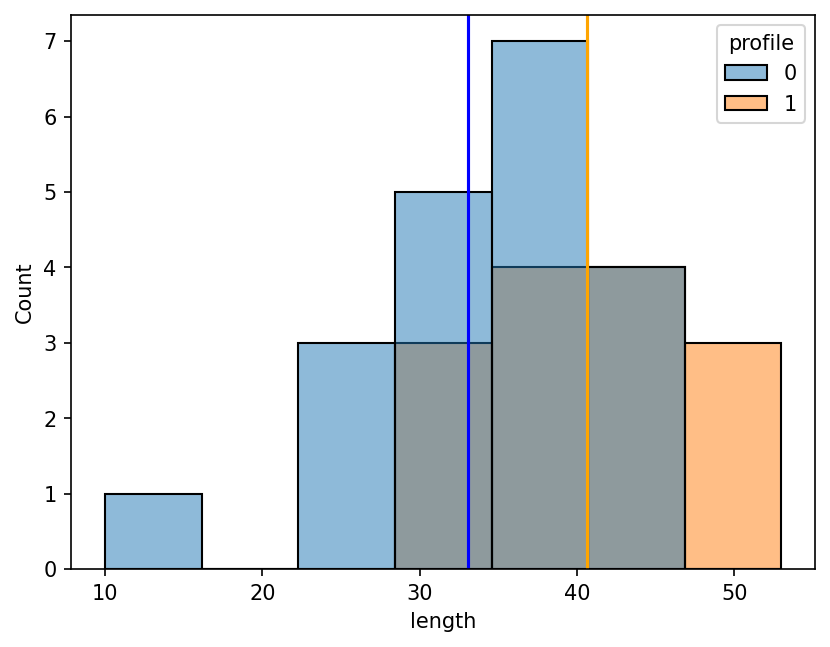

In [93]:
# Plot the distribution of path lengths for each signaling profile
plt.figure(dpi=150)
sns.histplot(data=path_length_df, x='length', hue='profile')
# Plot the mean path length for each signaling profile as vertical lines using same color code
wt_like_mean = path_length_df[path_length_df.profile == 0].length.mean()
gi_like_mean = path_length_df[path_length_df.profile == 1].length.mean()
plt.axvline(wt_like_mean, color='blue')
plt.axvline(gi_like_mean, color='orange')
plt.show()

In [94]:
# Is there a particular interaction that is present in wt mutants but not in gi preferred mutants?
# build a unique list with all the edges in all the pathways
# remove resid 76 from allosteric_pathway_dict if present
if '76' in allosteric_pathway_dict.keys():
    del allosteric_pathway_dict['76']
all_pathway_edges = []
for mutant_id, pathway_edges in allosteric_pathway_dict.items():
    all_pathway_edges += pathway_edges
all_pathway_edges = set(all_pathway_edges)

# For each edge, compute its prevalence among wt and gi preferred mutants
edge_prevalence_list = []
for edge in all_pathway_edges:
    wt_prevalence = 0
    gi_prevalence = 0
    for mutant_id, pathway_edges in allosteric_pathway_dict.items():
        # continue if mutant id not in signaling df index
        if mutant_id != 'WT' and mutant_id not in signaling_df.index:
            continue
        if edge in pathway_edges:
            if mutant_id == 'WT' or signaling_df.loc[mutant_id].profile == 0:
                wt_prevalence += 1
            elif signaling_df.loc[mutant_id].profile == 1:
                gi_prevalence += 1

    # Normalize the prevalence by the number of mutants in each profile in allosteric_pathway_dict
    wt_prevalence = wt_prevalence / len([mutant_id for mutant_id in allosteric_pathway_dict.keys(
    ) if mutant_id == 'WT' or signaling_df.loc[mutant_id].profile == 0])
    gi_prevalence = gi_prevalence / len([mutant_id for mutant_id in allosteric_pathway_dict.keys(
    ) if mutant_id != 'WT' and signaling_df.loc[mutant_id].profile == 1])

    edge_prevalence_list.append([edge, wt_prevalence, gi_prevalence])
# cast the list into a dataframe
edge_prevalence_df = pd.DataFrame(edge_prevalence_list, columns=[
                                  'edge', 'wt_prevalence', 'gi_prevalence'])

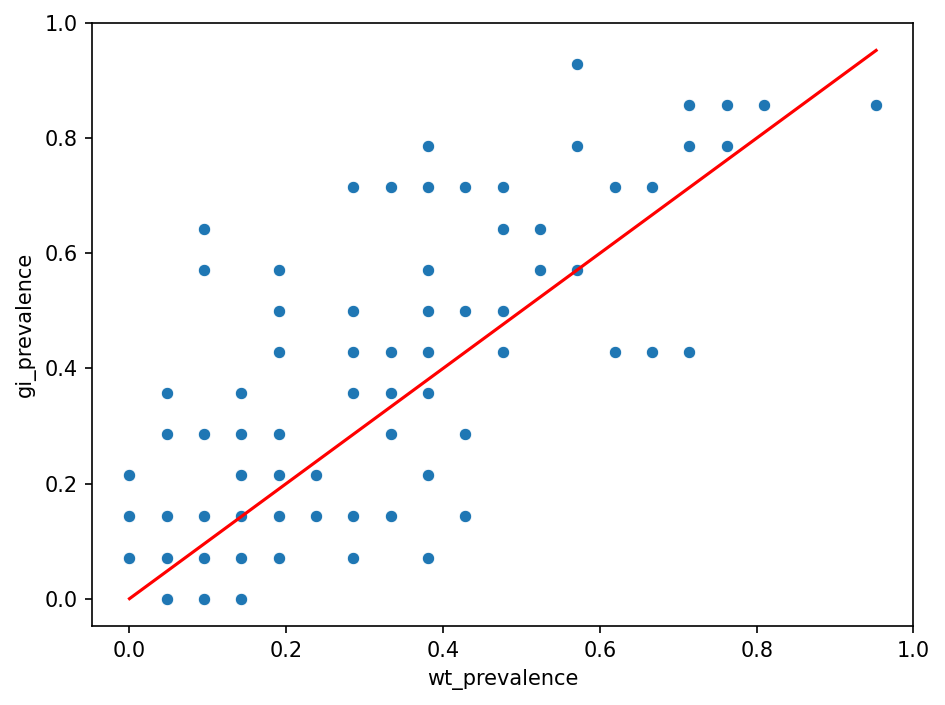

In [95]:
# Scatterplot of wt vs gi preferred prevalence
plt.figure(dpi=150)
sns.scatterplot(data=edge_prevalence_df, x='wt_prevalence', y='gi_prevalence')
# Plot a line with slope 1 to mark the diagonal from 0,0 to max prevalence value
plt.plot([0, edge_prevalence_df.wt_prevalence.max()], [
         0, edge_prevalence_df.wt_prevalence.max()], color='red')
plt.tight_layout()
plt.show()

In [96]:
# build a distance matrix between all mutants based on the jacard coefficient
# declare a list to store the distance matrix
distance_matrix = []
# iterate over all mutants
for mutant_id, pathway_edges in allosteric_pathway_dict.items():
    # declare a list to store the distance of the mutant to all other mutants
    distance_list = []
    # iterate over all mutants
    for other_mutant_id, other_pathway_edges in allosteric_pathway_dict.items():
        # compute the jaccard coefficient between the two mutants
        jaccard_coeff = len(set(pathway_edges).intersection(
            other_pathway_edges)) / len(set(pathway_edges).union(other_pathway_edges))
        # append the distance to the list
        distance_list.append(jaccard_coeff)
    # append the distance list to the distance matrix
    distance_matrix.append(distance_list)
# cast the distance matrix into a dataframe
distance_matrix_df = pd.DataFrame(distance_matrix, index=allosteric_pathway_dict.keys(
), columns=allosteric_pathway_dict.keys())

<Figure size 960x720 with 0 Axes>

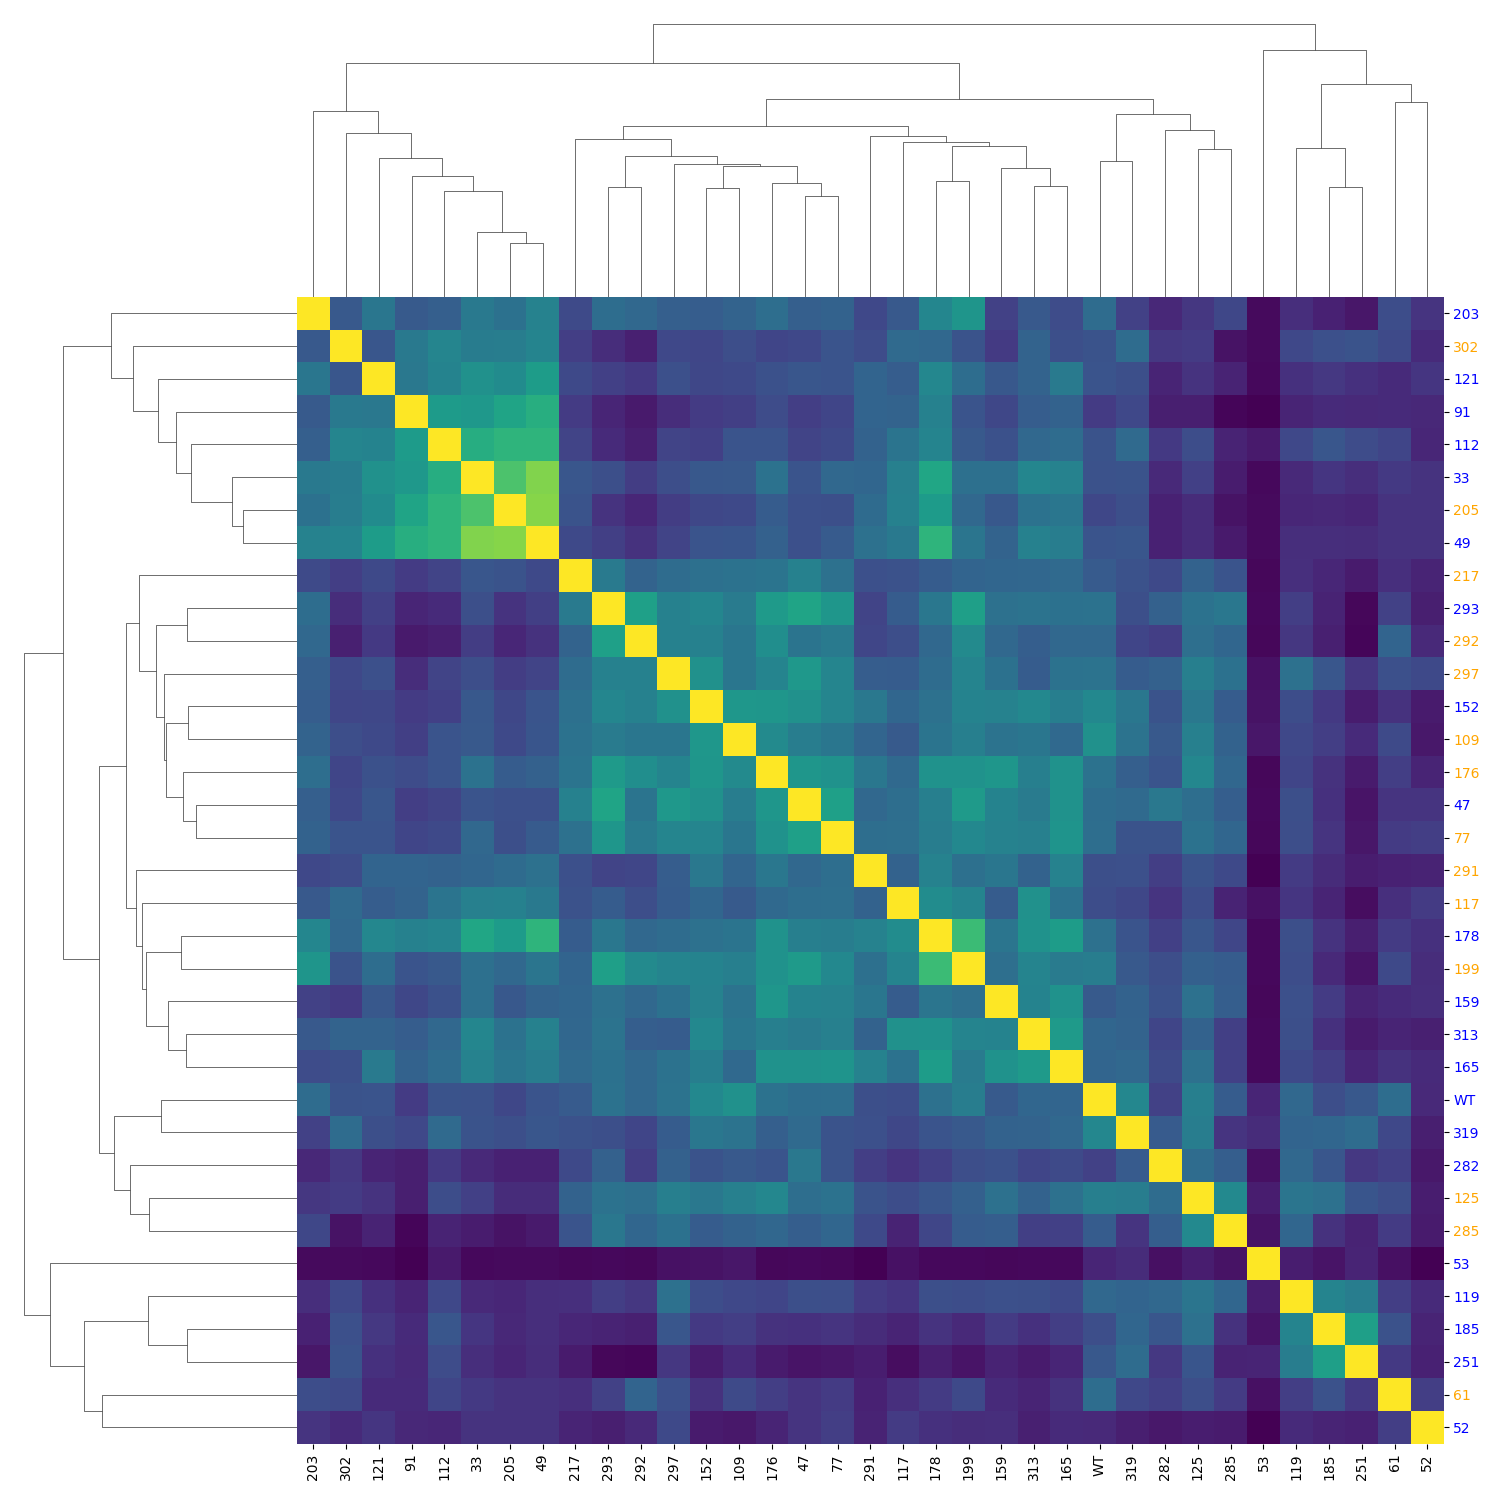

In [97]:
# plot al clustermap of the distance matrix showing all ticks
plt.figure(dpi=150)
dendrogram = sns.clustermap(data=distance_matrix_df,
                            cmap='viridis', figsize=(15, 15), cbar_pos=None)
# rotated the yticks
plt.yticks(rotation=0)
# color the dendrogram according to the signaling profile
for i, label in enumerate(dendrogram.ax_heatmap.get_yticklabels()):
    if label.get_text() == 'WT':
        label.set_color('blue')
    elif signaling_df.loc[label.get_text()].profile == 0:
        label.set_color('blue')
    elif signaling_df.loc[label.get_text()].profile == 1:
        label.set_color('orange')
# set background color to white
# sns.set(rc = {'axes.facecolor': 'white'})

plt.show()

# Compare the degree of PrefCoup residues and the wt residues

In [116]:
signaling_df.profile.value_counts()

profile
0    250
1     64
Name: count, dtype: int64

In [117]:
# get the degree of prefcoup residues
degree_df = []
for position, profile in signaling_df.iterrows():
    position = int(position)
    print(position)
    if int(position) not in graph.nodes():
        continue

    degree = graph.degree(position)
    print('D:', degree)
    degree_df.append([position, degree, profile[0]])

1
D: 23
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
D: 13
20
D: 14
21
D: 6
22
D: 10
23
D: 7
24
D: 8
25
D: 12
26
D: 8
27
D: 6
28
D: 6
29
D: 4
30
D: 4
31
D: 4
32
D: 6
33
D: 11
34
D: 6
35
D: 6
36
D: 10
37
D: 7
38
D: 6
39
D: 7
40
D: 12
41
D: 7
42
D: 6
44
D: 9
45
D: 6
46
D: 7
47
D: 10
48
D: 9
49
D: 6
50
D: 9
52
D: 7
53
D: 6
54
D: 8
55
D: 9
56
D: 7
57
D: 11
59
D: 5
60
D: 7
61
D: 8
62
D: 6
63
D: 8
65
D: 9
66
D: 7
67
D: 10
68
D: 8
69
D: 10
71
D: 11
74
D: 8
77
D: 8
78
D: 7
81
D: 10
82
D: 8
84
D: 10
85
D: 7
86
D: 8
87
D: 11
88
D: 8
89
D: 6
90
D: 9
91
D: 11
92
D: 9
93
D: 10
94
D: 13
95
D: 9
96
D: 5
97
D: 4
98
D: 9
99
D: 7
100
D: 5
101
D: 9
102
D: 4
103
D: 9
104
D: 5
105
D: 6
106
D: 12
108
D: 8
109
D: 11
110
D: 9
112
D: 8
113
D: 9
114
D: 10
115
D: 11
116
D: 10
117
D: 9
119
D: 9
121
D: 9
122
D: 7
123
D: 10
124
D: 12
125
D: 10
126
D: 10
127
D: 9
129
D: 7
131
D: 11
134
D: 8
136
D: 8
137
D: 6
138
D: 4
139
D: 4
140
D: 7
141
D: 13
142
D: 9
143
D: 5
144
D: 6
145
D: 10
147
D: 9
148
D: 4
149
D: 8
150
D: 

In [118]:
degree_df = pd.DataFrame(degree_df, columns=['node', 'degree', 'profile'])

In [119]:
# drop node 1
degree_df = degree_df[degree_df['node'] != 1]

In [120]:
degree_df

,node,degree,profile
1,19,13,0
2,20,14,0
3,21,6,0
4,22,10,0
5,23,7,0
...,...,...,...
239,315,6,0
240,316,6,0
241,317,4,1
242,318,4,0


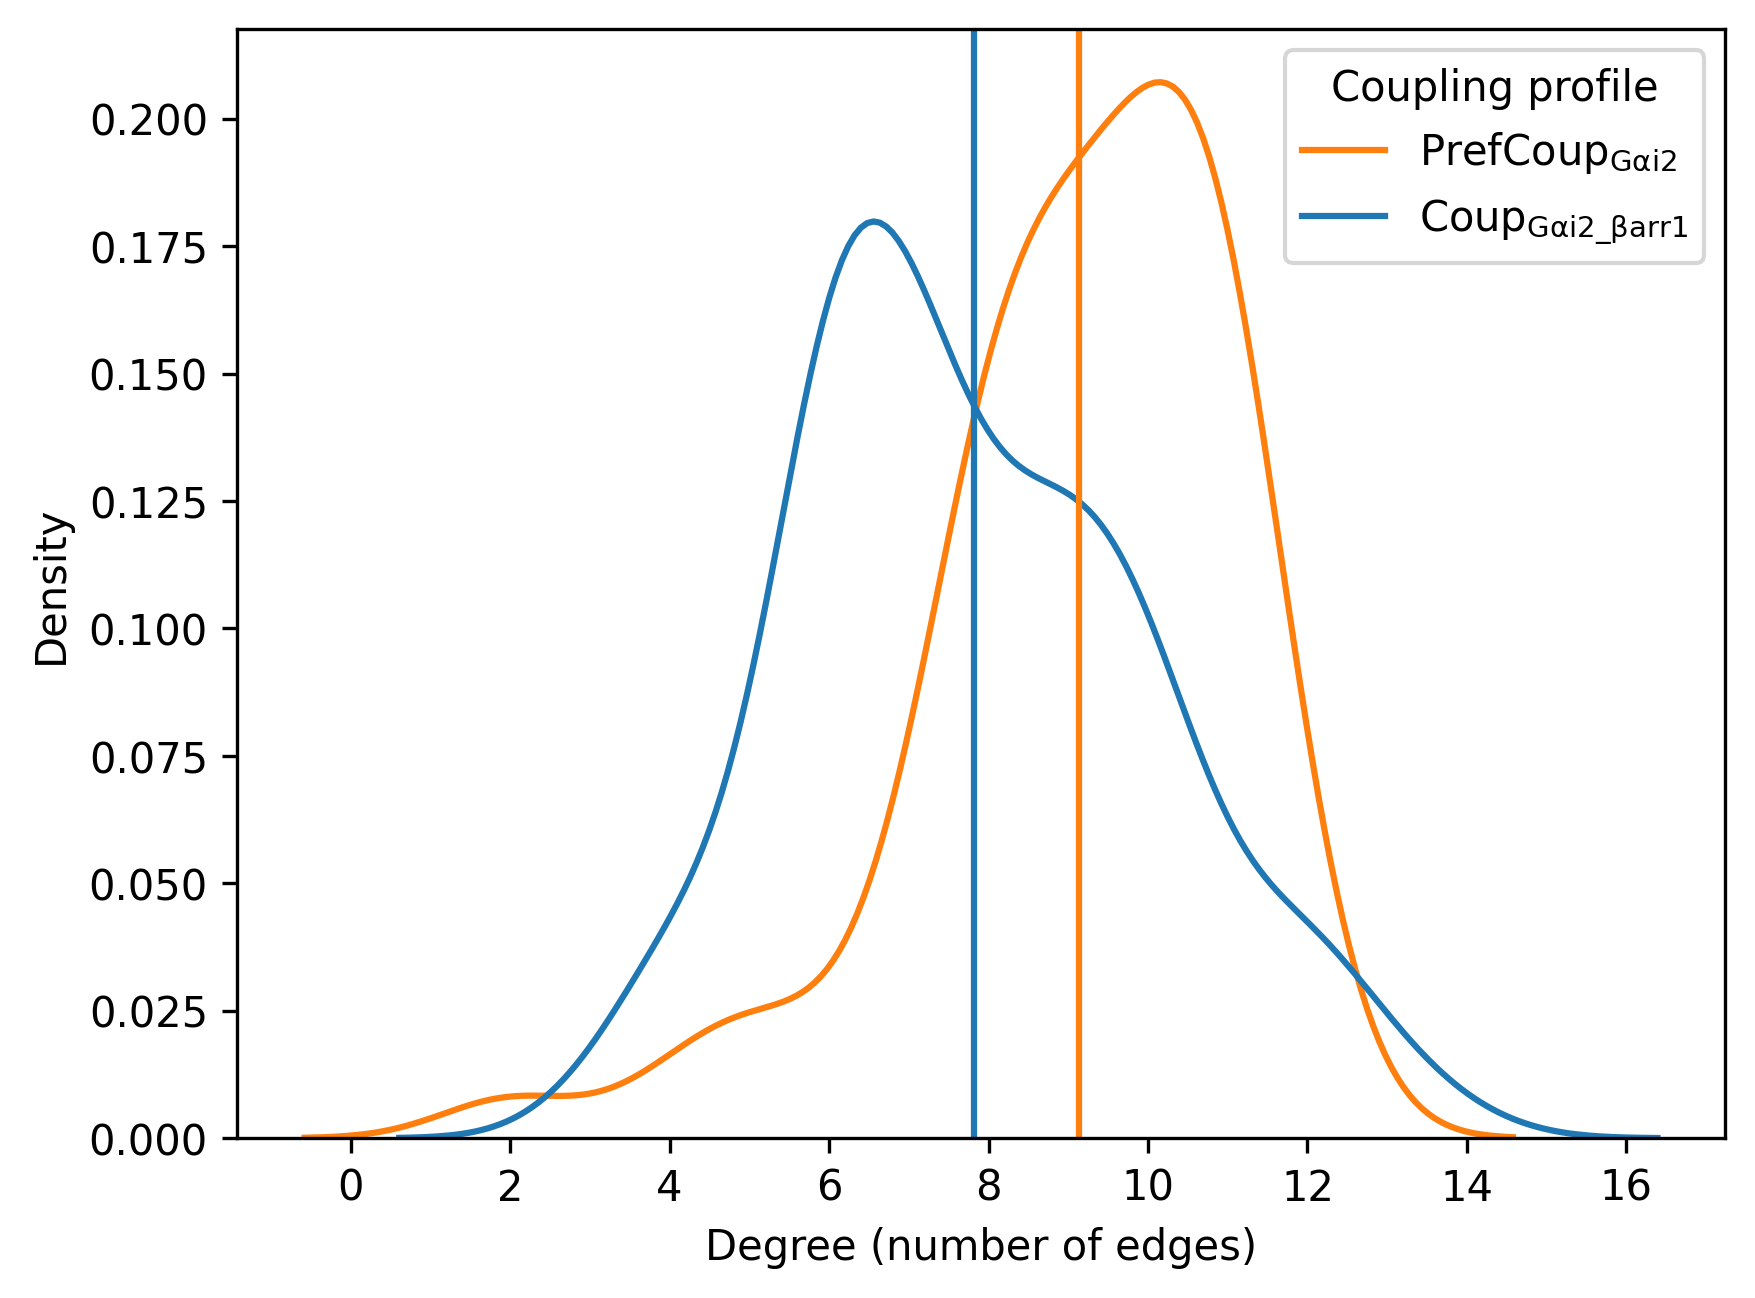

In [121]:
# sns.histplot(data=degree_df, x='degree', bins=100,
#              hue='profile', stat='proportion', common_norm=False)

plt.figure(dpi=300)
# change font size
plt.rcParams.update({'font.size': 10})
g = sns.kdeplot(data=degree_df, x='degree', hue='profile', common_norm=False)

# plt.xlim(-0.5, 22)

plt.legend(title='Coupling profile', labels= [r'$\mathrm{PrefCoup_{G\alpha i2}}$',
                                              r'$\mathrm{Coup_{G\alpha i2\_\beta arr1}}$'])

# show only whole numbers on the x axis
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Degree (number of edges)')

# plot the mean of each profile
plt.axvline(x=degree_df[degree_df['profile'] == 0]
            ['degree'].mean(), color=sns.color_palette()[0])
plt.axvline(x=degree_df[degree_df['profile'] == 1]
            ['degree'].mean(), color=sns.color_palette()[1])
plt.show()

In [122]:
# check if the degree of biased mutants is higher than the degree of wt-like mutants using a t-test
bisa_degree = degree_df[degree_df['profile'] == 1]['degree'].values
wt_degree = degree_df[degree_df['profile'] == 0]['degree'].values

statistic, pvalue = stats.ttest_ind(bisa_degree, wt_degree)
print('pvalue:', pvalue)

pvalue: 7.039615415172155e-05


# Check quantitative coupling in the ACN

In [135]:
expression_df = pd.read_csv(
    'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv')
expression_df['acn'] = expression_df['Position'].apply(
    lambda x: x in map(str, pathway_residues))

In [136]:
expression_df.columns

Index(['Mutant', 'Position', 'GPCRdb', '%wt expression',
       'Emax_avg_corr_Gi2_HU210', 'Emax_avg_corr_Gi2_SR144528',
       'Emax_avg_corr_GoB_HU210', 'Emax_avg_corr_GoB_SR144528',
       'Emax_avg_corr_bArr1_HU210', 'Emax_avg_corr_bArr2_HU210',
       'EC50_avg_corr_Gi2_HU210', 'EC50_avg_corr_Gi2_SR144528',
       'EC50_avg_corr_GoB_HU210', 'EC50_avg_corr_GoB_SR144528',
       'EC50_avg_corr_bArr1_HU210', 'EC50_avg_corr_bArr2_HU210', 'acn'],
      dtype='object')

In [137]:
expression_df = expression_df[[
    'Position', 'Emax_avg_corr_Gi2_HU210', 'Emax_avg_corr_bArr1_HU210', 'acn']]

In [138]:
expression_df.columns = ['resid', 'gi', 'barr', 'acn']

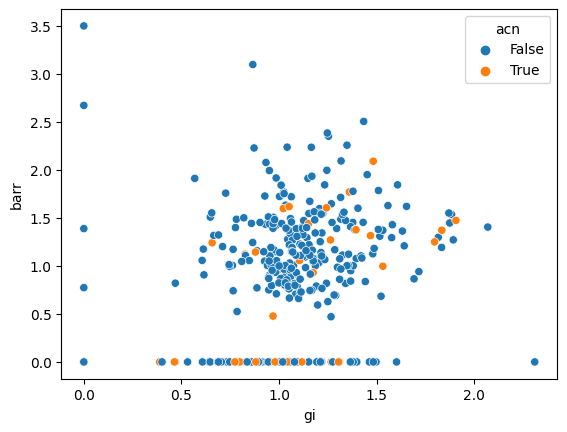

In [139]:
sns.scatterplot(data=expression_df, x='gi', y='barr', hue='acn')
plt.show()

# Check degree for residues at a distance of 1 from the ACN vs the residues within the ACN

In [140]:
# Compute distnace to the ACN of all nodes in the contact graph
distances_df = get_distances_to_shortest_pathway(
    graph, pathway_residues, graph.nodes())

In [141]:
degree_list = []

for node in graph.nodes():
    degree_list.append([node, graph.degree(node)])
degree_df = pd.DataFrame(degree_list, columns=['node', 'degree'])

In [142]:
distance_degree_df = pd.merge(
    degree_df, distances_df, left_on='node', right_on='residue')

In [143]:
distance_degree_df.node = distance_degree_df.node.astype(str)

In [144]:
degree_profile_degree_df = pd.merge(
    distance_degree_df, signaling_df, left_on='node', right_on='position')

In [145]:
degree_profile_degree_df = degree_profile_degree_df[~(
    degree_profile_degree_df.node == '1')]

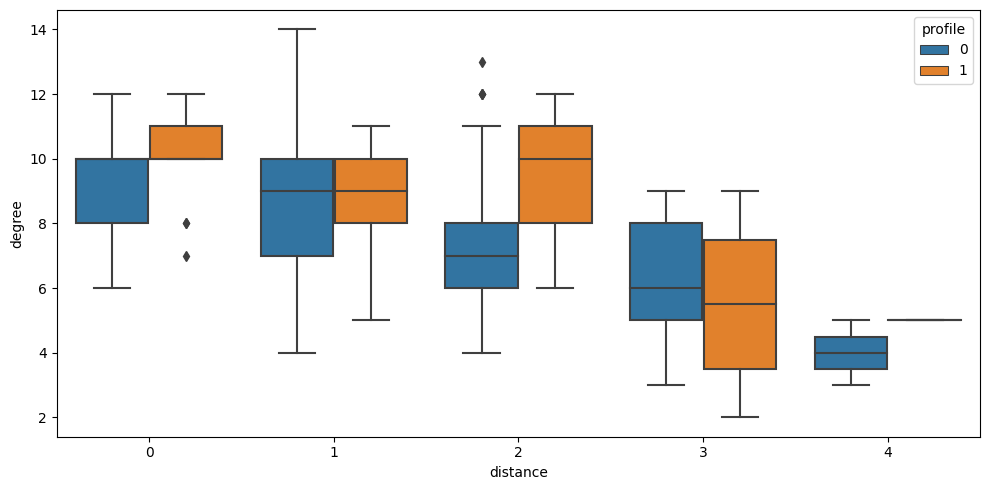

In [146]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=degree_profile_degree_df,
            x='distance', y='degree', hue='profile')
plt.tight_layout()
plt.show()

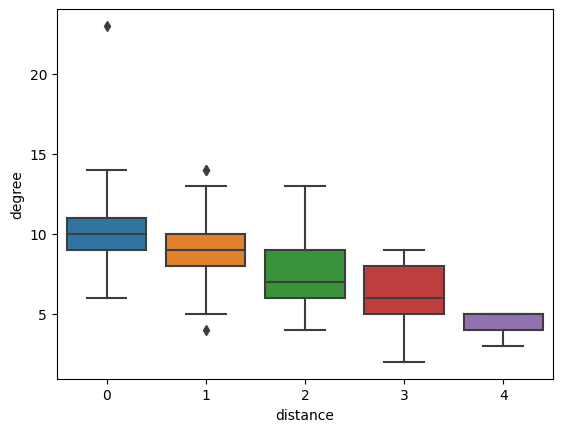

In [147]:
sns.boxplot(data=distance_degree_df, x='distance', y='degree')
plt.show()

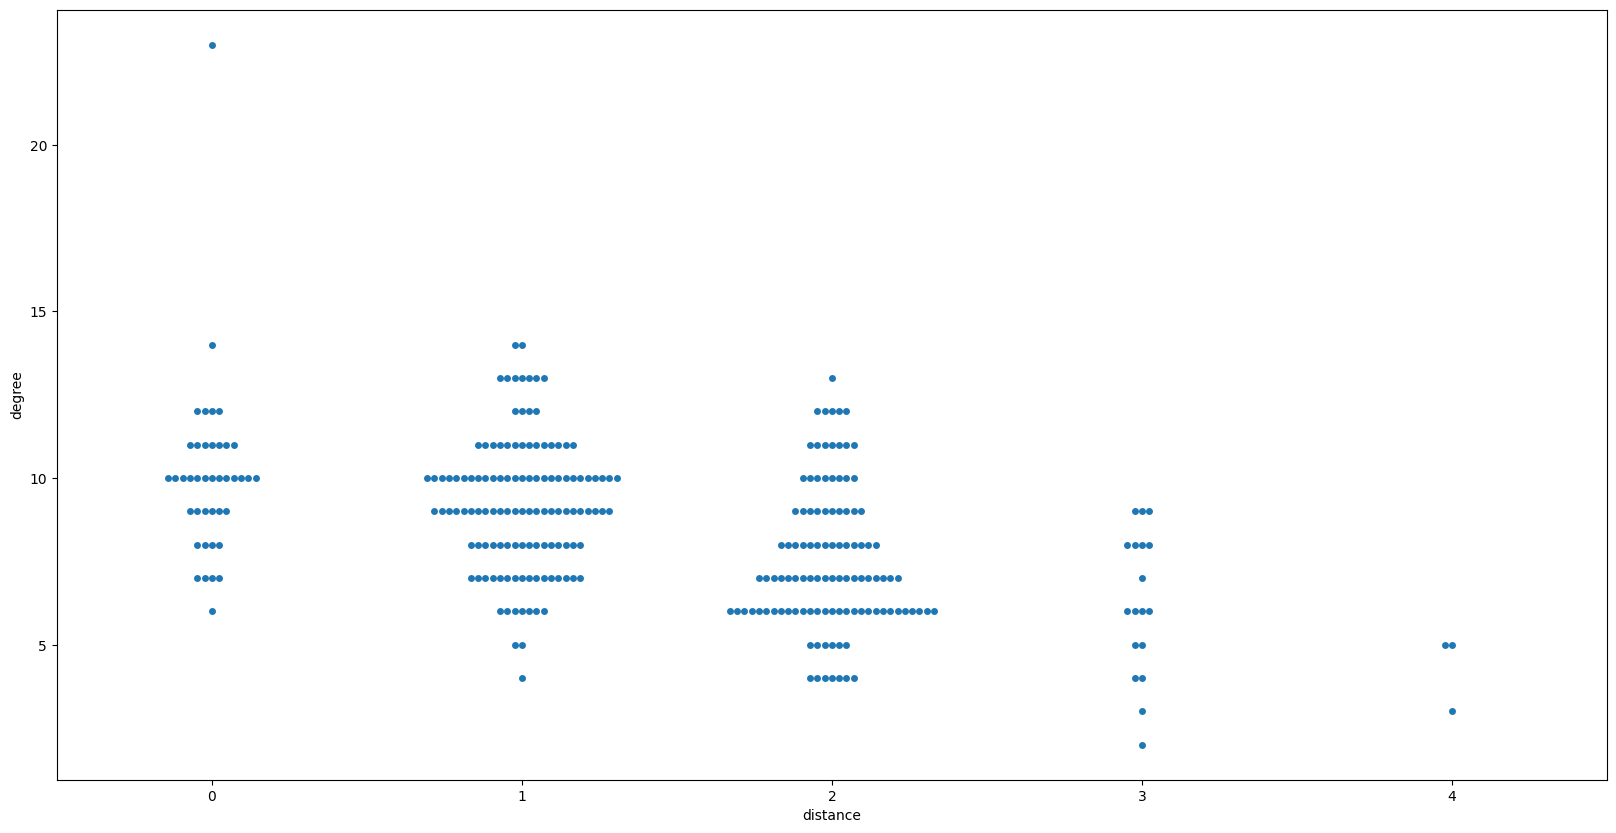

In [148]:
plt.figure(figsize=(20, 10))
sns.swarmplot(data=distance_degree_df, x='distance', y='degree')
plt.show()

<Axes: xlabel='distance', ylabel='count'>

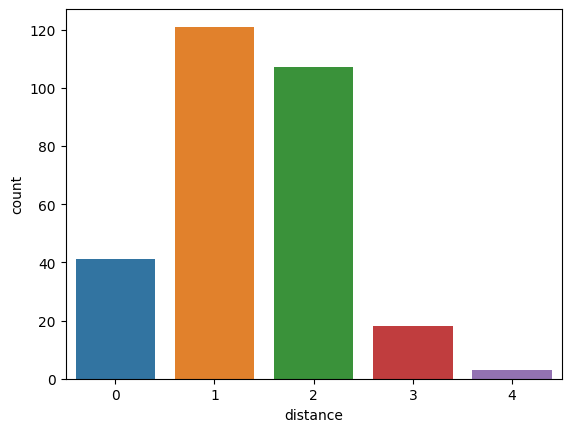

In [149]:
sns.countplot(x='distance', data=distance_degree_df)

In [150]:
graph.nodes()

NodeView((193, 197, 37, 41, 133, 141, 215, 218, 134, 138, 280, 283, 213, 1, 87, 191, 194, 22, 24, 62, 64, 167, 170, 19, 185, 314, 318, 202, 204, 106, 110, 263, 267, 275, 279, 50, 293, 153, 155, 92, 96, 164, 190, 51, 299, 82, 116, 246, 250, 112, 114, 206, 210, 196, 199, 209, 244, 300, 307, 147, 149, 47, 84, 150, 152, 303, 305, 302, 44, 71, 75, 25, 282, 257, 259, 311, 119, 123, 315, 189, 27, 29, 36, 40, 125, 128, 86, 60, 285, 139, 278, 281, 183, 115, 166, 289, 180, 268, 127, 273, 294, 296, 177, 135, 70, 72, 117, 198, 200, 39, 111, 113, 163, 292, 20, 179, 247, 251, 81, 45, 277, 165, 261, 265, 158, 239, 53, 57, 31, 34, 214, 216, 242, 173, 30, 42, 46, 148, 151, 269, 69, 122, 157, 205, 207, 131, 212, 59, 121, 32, 276, 211, 73, 67, 248, 252, 201, 291, 220, 91, 95, 235, 238, 217, 188, 192, 65, 55, 58, 306, 310, 54, 255, 249, 56, 102, 104, 144, 101, 109, 79, 83, 160, 78, 33, 98, 61, 63, 38, 203, 181, 154, 26, 184, 208, 271, 48, 120, 253, 182, 93, 43, 286, 156, 108, 258, 124, 241, 243, 97, 99, 2

# Check sizes of the ACN

In [151]:
best_threshold

0.146

In [152]:
acn_size_list = []
path_df_list = []
for file in glob(f'results/allosteric_network_distance/ACN_filering_thresholds/{ACN}/transition_matrices/*'):

    path_df = parse_pathway_data(file)
    acn_list = path_df_to_list(path_df, best_threshold)

    mutant_id = os.path.basename(file).split('_')[0]

    # Add the mutant id to the path df
    path_df['mutant_id'] = mutant_id
    path_df_list.append(path_df)

    acn_size = len(acn_list)
    acn_size_list.append([acn_size, mutant_id])

In [153]:
all_path_df = pd.concat(path_df_list)

all_path_df = all_path_df[all_path_df.value > best_threshold]

all_path_df = pd.merge(all_path_df, signaling_df,
                       left_on='mutant_id', right_index=True, how='left')

In [154]:
all_path_mean_dg = pd.merge(all_path_df.groupby('mutant_id').value.mean(), signaling_df, left_index=True, right_index=True)

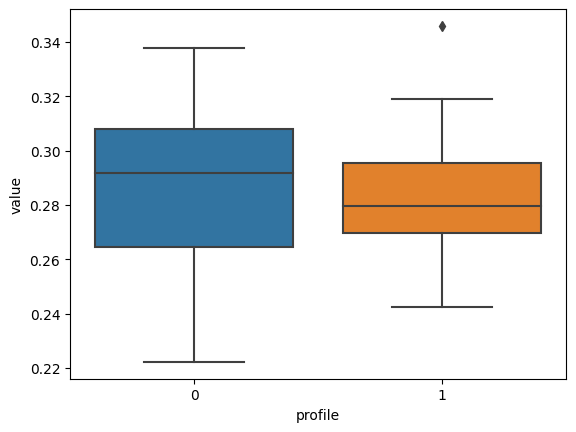

In [155]:
sns.boxplot(data=all_path_mean_dg, x='profile', y='value')
plt.show()

In [156]:
# Assess if the difference in value between the two profiles is statistically significant
wt_like_values = all_path_mean_dg[all_path_mean_dg.profile == 0].value
gi_like_values = all_path_mean_dg[all_path_mean_dg.profile == 1].value

statistic, pvalue = stats.ttest_ind(wt_like_values, gi_like_values)
print('p-value: ', pvalue)

p-value:  0.8520352256564271


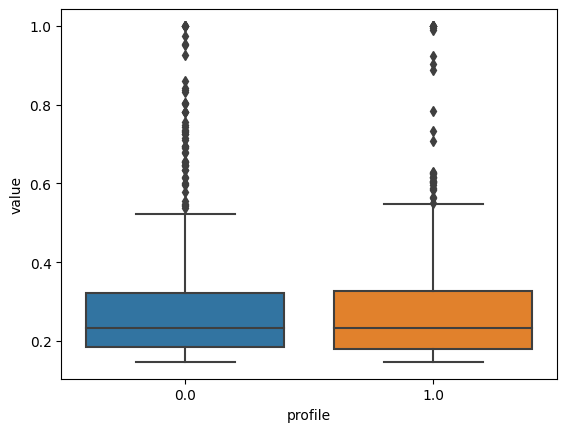

In [157]:
sns.boxplot(data=all_path_df, x='profile', y='value')
plt.show()

In [158]:
all_path_df

,r1,r2,value,mutant_id,profile
459,305,303,0.2015,302,1.0
684,83,81,0.2280,302,1.0
1230,76,73,0.1500,302,1.0
1519,162,164,0.1510,302,1.0
1860,295,297,0.3570,302,1.0
...,...,...,...,...,...
6265,288,290,0.3325,292,1.0
6364,291,295,0.4995,292,1.0
6584,258,254,0.1740,292,1.0
6679,285,283,0.2600,292,1.0


In [159]:
acn_size_df = pd.DataFrame(acn_size_list, columns=['acn_size', 'mutant_id'])

In [160]:
acn_size_df = pd.merge(acn_size_df, signaling_df,
                       left_on='mutant_id', right_index=True, how='left')

In [161]:
acn_size_df.fillna(0, inplace=True)

In [162]:
acn_size_df[acn_size_df.mutant_id == 'WT']

,acn_size,mutant_id,profile
7,41,WT,0.0


In [163]:
sns.reset_defaults()

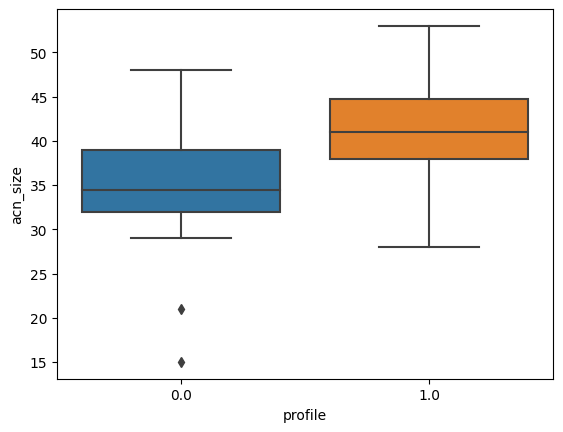

In [165]:
# plt.figure(dpi=150)
sns.boxplot(acn_size_df, y='acn_size', x='profile')
# plt.axhline(y=acn_size_df[acn_size_df.mutant_id == 'WT']['acn_size'].mean(), color='red')
# Show that the difference between the two sets is statistically significant using a line connecting the two groups and asterisks
# plt.plot([0, 1], [acn_size_df.acn_size.max() * 1.05]*2, marker='|', markersize=12, color='k')
# plt.text(0.5, acn_size_df.acn_size.max() * 1.06, '*', ha='center', va='center', fontsize=12)
# Change the tick labels 
# plt.xticks([0, 1], ['$\mathrm{Coup_{G_i\_Barr_1}}$', '$\mathrm{PrefCoup_{G_i}}$', ])
plt.show()

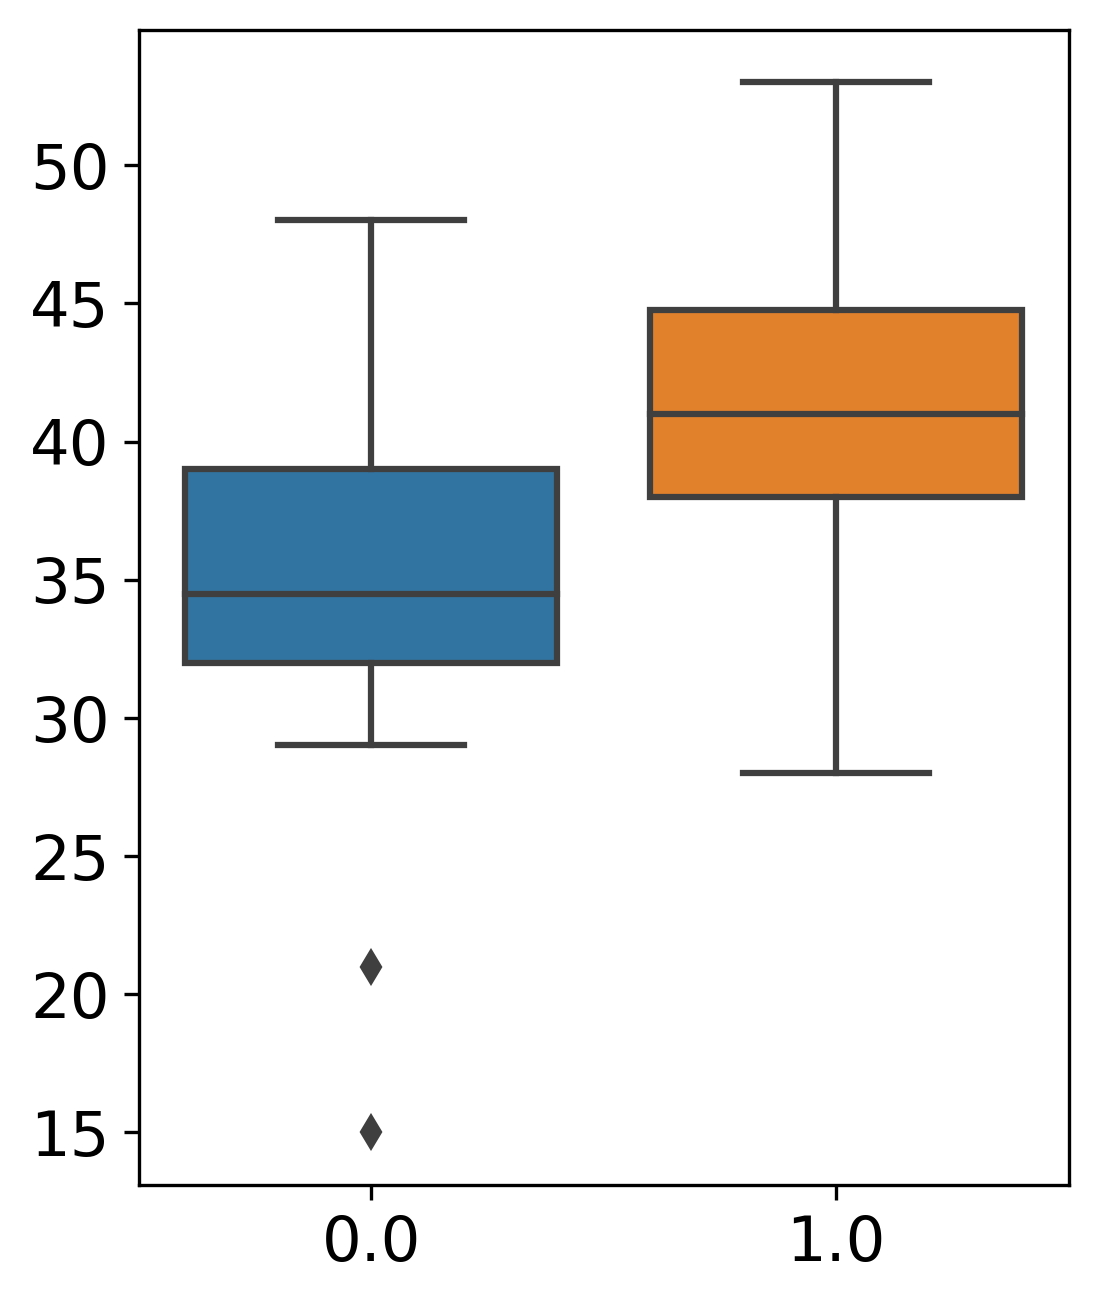

In [175]:
plt.figure(dpi=300, figsize=(4, 5))
# Increase the size of the fonts
plt.rcParams.update({'font.size': 15})
sns.boxplot(acn_size_df, y='acn_size', x='profile')
plt.xlabel("")
plt.ylabel("")
plt.show()

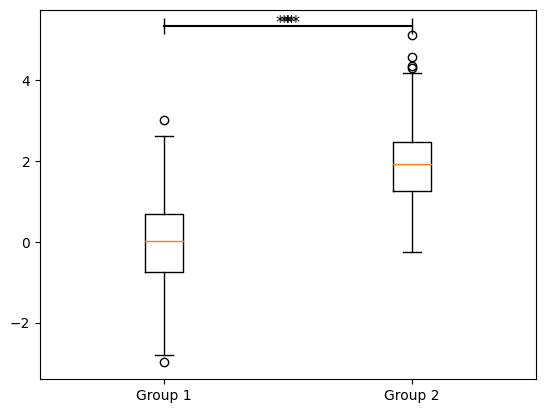

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Generate example data (replace with your own datasets)
data1 = np.random.normal(0, 1, 100)
data2 = np.random.normal(2, 1, 100)

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(data1, data2)

# Set significance levels
alpha_levels = [0.001, 0.01, 0.05]
significance_symbols = ['***', '**', '*']

# Create a boxplot and connect with a line
bp = plt.boxplot([data1, data2], labels=['Group 1', 'Group 2'])
plt.plot([1, 2], [max(max(data1), max(data2)) + 0.2] * 2, marker='|', markersize=12, color='k')

# Annotate with asterisks based on significance
for i, alpha in enumerate(alpha_levels):
    if p_value < alpha:
        plt.text(1.5, max(max(data1), max(data2)) + 0.3, significance_symbols[i], ha='center', va='center', fontsize=12)

# Display the plot
plt.show()

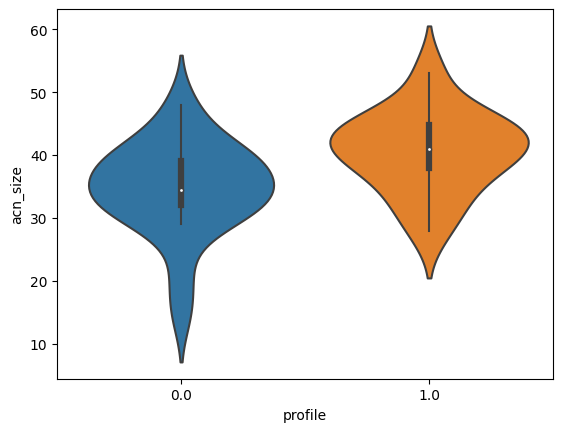

In [161]:
# plt.figure(dpi=150)
sns.violinplot(acn_size_df, y='acn_size', x='profile')
# plt.axhline(y=acn_size_df[acn_size_df.mutant_id == 'WT']['acn_size'].mean(), color='red')
plt.show()

In [162]:
import scipy.stats as stats

In [163]:
# compute statistical significance
# (using Kolmogorov-Smirnov test)
# if yes, then the two distributions are different, and we can use the
biased_acn_sizes = acn_size_df[acn_size_df['profile'] == 1]['acn_size']
non_biased_acn_sizes = acn_size_df[acn_size_df['profile'] == 0]['acn_size']
statistic, pvalue = stats.ttest_ind(biased_acn_sizes, non_biased_acn_sizes)

In [164]:
pvalue

0.018631891533855496